<center>
<h4>CDS 110, Lecture 4b</h4>
<font color=blue><h1>LQR Tracking</h1></font>
<h3>Richard M. Murray and Natalie Bernat, Winter 2024</h3>
</center>

[Open in Google Colab](https://colab.research.google.com/drive/1hMR9YfmWJZ72r9_eObeA9JKkpTt-jDtM)

This example uses a linear system to show how to implement LQR based tracking and some of the tradeoffs between feedfoward and feedback.  Integral action is also implemented.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
try:
  import control as ct
  print("python-control", ct.__version__)
except ImportError:
  !pip install control
  import control as ct

python-control 0.10.1.dev32+gdbc998de


# Part I: Second order linear system

We'll use a simple linear system to illustrate the concepts:
$$
\frac{dx}{dt} =
\begin{bmatrix}
0 & 10 \\
-1 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0  \\
1
\end{bmatrix}
u,
\qquad
y = \begin{bmatrix} 1  \\ 1  \end{bmatrix} x.
$$

<!-- This system corresponds to the linearized lateral dynamics of a vehicle driving down a road at 10 m/s. -->

In [34]:
# Define a simple linear system that we want to control
A = np.array([[0, 10], [-1, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 1]])
sys = ct.ss(A, B, C, 0, name='sys')
print(sys)

<StateSpace>: sys
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0. 10.]
     [-1.  0.]]

B = [[0.]
     [1.]]

C = [[1. 1.]]

D = [[0.]]



## Linear quadratic regulator (LQR) design

We'll design a controller of the form

$$
u=-Kx+k_rr
$$

- For the feedback control gain $K$, we'll use linear quadratic regulator theory.  We seek to find the control law that minimizes the cost function:

  $$
  J(x(\cdot), u(\cdot)) = \int_0^\infty x^T(\tau) Q x(\tau) + u^T(\tau) R u(\tau)\, d\tau
  $$

  The weighting matrices $Q\succeq 0 \in \mathbb{R}^{n \times n}$ and $R \succ 0\in \mathbb{R}^{m \times m}$ should be chosen based on the desired performance of the system (tradeoffs in state errors and input magnitudes).  See Example 3.5 in [Optimization Based Control (OBC)](https://fbswiki.org/wiki/index.php/Supplement:_Optimization-Based_Control) for a discussion of how to choose these weights.  For now, we just choose identity weights for all states and inputs.

- For the feedforward control gain $k_r$, we derive the feedforward gain from an equilibrium point analysis:
  $$
  y_e = C(A-BK)^{-1}Bk_rr
  \qquad\implies\qquad k_r = \frac{-1}{C(A-BK)^{-1}B}
  $$

In [35]:
# Construct an LQR controller for the system
Q = np.eye(sys.nstates)
R = np.eye(sys.ninputs)
K, _, _ = ct.lqr(sys, Q, R)
print('K: '+str(K))

# Set the feedforward gain to track the reference
kr = (-1 / (C @ np.linalg.inv(A - B @ K) @ B))
print('k_r: '+str(kr))

K: [[0.41421356 3.04701021]]
k_r: [[1.41421356]]


Now that we have our gains designed, we can simulate the closed loop system:
$$
\frac{dx}{dt} = A_{cl}x + B_{cl} r,
\quad A_{cl} = A-BK,
\quad B_{cl} = Bk_r
$$
Notice that, with a state feedback controller, the new (closed loop) dynamics matrix absorbs the old (open loop) "input" $u$, and the new (closed loop) input is our reference signal $r$.

In [36]:
# Create a closed loop system
A_cl = A - B @ K
B_cl =  B * kr
clsys = ct.ss(A_cl, B_cl, C, 0)
print(clsys)

<StateSpace>: sys[9]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.         10.        ]
     [-1.41421356 -3.04701021]]

B = [[0.        ]
     [1.41421356]]

C = [[1. 1.]]

D = [[0.]]



## System simulations

### Baseline controller

To see how the baseline controller performs, we ask it to track a constant reference $r = 2$:

Text(0.5, 1.0, 'Baseline controller step response')

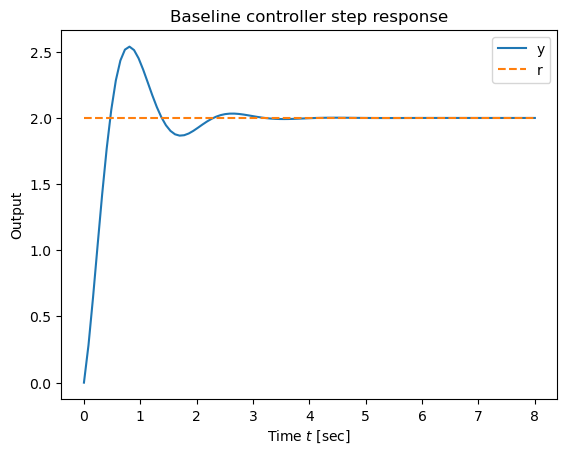

In [37]:
# Plot the step response with respect to the reference input
r = 2
Tf = 8
tvec = np.linspace(0, Tf, 100)

U = r * np.ones_like(tvec)
time, output = ct.input_output_response(clsys, tvec, U)
plt.plot(time, output)
plt.plot([time[0], time[-1]], [r, r], '--');
plt.legend(['y', 'r']);
plt.ylabel("Output")
plt.xlabel("Time $t$ [sec]")
plt.title("Baseline controller step response")

Things to try:
- set $k_r=0$
- set $k_r \neq \frac{-1}{C(A-BK)^{-1}B}$
- try different LQR weightings

### Disturbance rejection

To add an input disturbance to the system, we include a second open loop input:
$$
\frac{dx}{dt} =
\begin{bmatrix}
0 & 10 \\
-1 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 & 0\\
1 & 1
\end{bmatrix}
\begin{bmatrix}
u\\
d
\end{bmatrix},
\qquad
y = \begin{bmatrix} 1 \\ 1 \end{bmatrix} x.
$$

Our closed loop system becomes:
$$
\frac{dx}{dt} =
\begin{bmatrix}
0 & 10 \\
-1-K_{1} & 0-K_{2}
\end{bmatrix}
x +
\begin{bmatrix}
0 & 0\\
k_r & 1
\end{bmatrix}
\begin{bmatrix}
r\\
d
\end{bmatrix},
\qquad
y = \begin{bmatrix} 1 \\ 1 \end{bmatrix} x.
$$

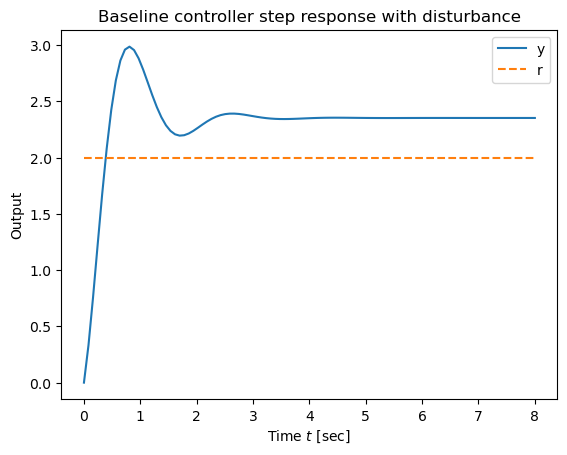

In [38]:
# Resimulate with a disturbance input
B_ext = np.hstack([B * kr, B])
clsys = ct.ss(A - B @ K, B_ext, C, 0)

# Construct the inputs for the augmented system
delta = 0.5
U = np.vstack([r * np.ones_like(tvec), delta * np.ones_like(tvec)])

time, output = ct.input_output_response(clsys, tvec, U)

plt.plot(time, output[0])
plt.plot([time[0], time[-1]], [r, r], '--')
plt.legend(['y', 'r']);
plt.ylabel("Output")
plt.xlabel("Time $t$ [sec]")
plt.title("Baseline controller step response with disturbance");

We see that this leads to steady state error, since the feedforward signal didn't include an offset for the disturbance.

#### Integral feedback

A standard approach to compensate for constant disturbances is to use integral feedback.  To do this, we have to keep track of the integral of the error

$$z = \int_0^\tau (y - r)\, d\tau= \int_0^\tau (Cx - r)\, d\tau.$$

We do this by creating an augmented system that includes the dynamics of the process ($dx/dt$) along with the dynamics of the integrator state ($dz/dt$):

$$
\frac{d}{dt}\begin{bmatrix}
x \\
z
\end{bmatrix} =
\begin{bmatrix}
A & 0 \\
C & 0
\end{bmatrix}
\begin{bmatrix}
x \\
z
\end{bmatrix} +
\begin{bmatrix}
B\\
0 \\
\end{bmatrix}
u+
\begin{bmatrix}
0\\
-I \\
\end{bmatrix}
r,
\qquad
y = \begin{bmatrix} C \\ 0 \end{bmatrix} \begin{bmatrix}
x \\
z
\end{bmatrix}.
$$


In [39]:
# Define an augmented state space for use with LQR
A_aug = np.block([[sys.A, np.zeros((sys.nstates, 1))], [C, 0] ])
B_aug = np.vstack([sys.B, 0])
print("A =", A_aug, "\nB =", B_aug)

A = [[ 0. 10.  0.]
 [-1.  0.  0.]
 [ 1.  1.  0.]] 
B = [[0.]
 [1.]
 [0.]]



Our controller then takes the form:

$$
\begin{aligned}
u &= - Kx - k_\text{i} \int_0^\tau (y - r)\, d\tau+k_rr \\
 &= - (Kx + k_\text{i}z)+k_rr .
\end{aligned}
$$

This results in the closed loop system:
$$
\frac{dx}{dt} =
\begin{bmatrix}
A-BK & -Bk_i \\
C & 0
\end{bmatrix}
\begin{bmatrix}
x \\
z
\end{bmatrix} +
\begin{bmatrix}
Bk_r\\
-I \\
\end{bmatrix}
r,
\qquad
y = \begin{bmatrix} C \\ 0 \end{bmatrix} \begin{bmatrix}
x \\
z
\end{bmatrix}.
$$

Since z is part of the augmented state space, we can generate an LQR controller for the the augmented system to find both the usual gain $K$ and the integral gain $k_i$:
$$
\bar{K} = \begin{bmatrix} K& k_i\end{bmatrix}
$$

In [40]:
# Create an LQR controller for the augmented system
K_aug, _, _ = ct.lqr(A_aug, B_aug, np.diag([1, 1, 1]), np.eye(sys.ninputs))
print('K_aug: '+str(K_aug))

K = K_aug[:, 0:2]
ki = K_aug[:, 2]
kr = -1 / (C @ np.linalg.inv(A - B * K) @ B)

K_aug: [[0.56288531 3.77593779 1.        ]]


<!-- We can think about this gain as `K_aug = [K, ki]` and the resulting contoller becomes -->


Notice that the value of $K$ changed, so we needed to recompute $k_r$ too.

To run simulations, we return to our system augmented with a disturbance, but we expand the outputs available to the controller:

$$
\frac{dx}{dt} =
\begin{bmatrix}
0 & 10 \\
-1 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 & 0\\
1 & 1
\end{bmatrix}
\begin{bmatrix}
u\\
d
\end{bmatrix},
$$

$$
\bar{y} = \begin{bmatrix} 1 & 0 & 1 \\ 0 & 1 & 1 \end{bmatrix}^T x = \begin{bmatrix} x_1 & x_2 & y \end{bmatrix}  .
$$

The controller then constructs its internal state $z$ out of $x$ and $r$.

<!-- $$
\frac{dx}{dt} =
\begin{bmatrix}
A-BK & -Bk_i \\
C & 0
\end{bmatrix}
\begin{bmatrix}
x \\
z
\end{bmatrix} +
\begin{bmatrix}
Bk_r & B\\
-I & 0 \\
\end{bmatrix}
\begin{bmatrix}
r \\
d
\end{bmatrix},
\qquad
y = \begin{bmatrix} C \\ 0 \end{bmatrix} \begin{bmatrix}
x \\
z
\end{bmatrix}.
$$ -->

<StateSpace>: sys[11]
Inputs (2): ['u', 'd']
Outputs (3): ['x1', 'x2', 'y']
States (2): ['x[0]', 'x[1]']

A = [[ 0. 10.]
     [-1.  0.]]

B = [[0. 0.]
     [1. 1.]]

C = [[1. 0.]
     [0. 1.]
     [1. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]]

<StateSpace>: sys[12]
Inputs (3): ['x1', 'x2', 'r']
Outputs (1): ['u']
States (1): ['x[0]']

A = [[0.]]

B = [[ 1.  1. -1.]]

C = [[-1.]]

D = [[-0.56288531 -3.77593779  1.56288531]]

<LinearICSystem>: sys[13]
Inputs (2): ['r', 'd']
Outputs (1): ['y']
States (3): ['sys[11]_x[0]', 'sys[11]_x[1]', 'sys[12]_x[0]']

A = [[ 0.         10.          0.        ]
     [-1.56288531 -3.77593779 -1.        ]
     [ 1.          1.          0.        ]]

B = [[ 0.          0.        ]
     [ 1.56288531  1.        ]
     [-1.          0.        ]]

C = [[1. 1. 0.]]

D = [[0. 0.]]



Text(0.5, 1.0, 'LQR+integral controller step response with disturbance')

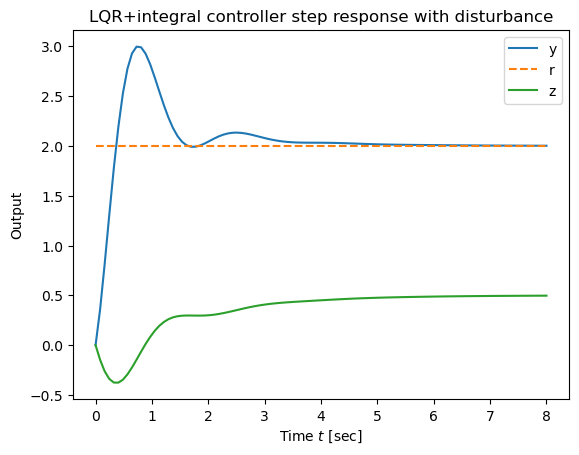

In [41]:
# Construct a system with disturbance inputs, and full outputs (for the controller)
A_integral = sys.A
B_integral = np.hstack([sys.B, sys.B])
C_integral = [[1, 0], [0, 1], [1, 1]] # outputs for the controller: x1, x2, y
sys_integral = ct.ss(
    A_integral, B_integral, C_integral, 0,
    inputs=['u', 'd'],
    outputs=['x1', 'x2', 'y']
)
print(sys_integral)

# Construct an LQR+integral controller for the system with an internal state z
A_ctrl = [[0]]
B_ctrl = [[1, 1, -1]] # z_dot=Cx-r
C_ctrl = -ki #-ki*z
D_ctrl = np.hstack([-K, kr]) #-K*x + kr*r
ctrl_integral=ct.ss(
    A_ctrl, B_ctrl, C_ctrl, D_ctrl, # u = -ki*z - K*x + kr*r
    inputs=['x1', 'x2', 'r'],    # system outputs + reference
    outputs=['u'],               # controller action
)
print(ctrl_integral)

# Create the closed loop system
clsys_integral = ct.interconnect([sys_integral, ctrl_integral], inputs=['r', 'd'], outputs=['y'])
print(clsys_integral)

# Resimulate with a disturbance input
delta = 0.5
U = np.vstack([r * np.ones_like(tvec), delta * np.ones_like(tvec)])
time, output, states = ct.input_output_response(clsys_integral, tvec, U, return_x=True)
plt.plot(time, output[0])
plt.plot([time[0], time[-1]], [r, r], '--')
plt.plot(time, states[2])
plt.legend(['y', 'r', 'z']);
plt.ylabel("Output")
plt.xlabel("Time $t$ [sec]")
plt.title("LQR+integral controller step response with disturbance")

Notice that the steady state value of $z=\int(y-r)$ is not zero, but rather settles to whatever value makes $y-r$ zero!
<!-- (If there's time: try setting ud=0 again to see what changes for the integral controller) -->

# Part 2: PVTOL Linear Quadratic Regulator Example

Natalie Bernat, 26 Apr 2024 <br>
Richard M. Murray, 25 Jan 2022

This notebook contains an example of LQR control applied to the PVTOL system.  It demonstrates how to construct an LQR controller by linearizing the system, and provides an alternate view of the feedforward component of the controller.

## System description

We use the PVTOL dynamics from [Feedback Systems (FBS2e)](https://fbswiki.org/wiki/index.php/Feedback_Systems:_An_Introduction_for_Scientists_and_Engineers), which can be found in Example 3.12}

<table>
<tr>
    <td width="30%"><img src="https://fbswiki.org/wiki/images/7/76/Pvtol.png" width=240></td>
    <td width="30%">
$$
\begin{aligned}
  m \ddot x &= F_1 \cos\theta - F_2 \sin\theta - c \dot x, \\
  m \ddot y &= F_1 \sin\theta + F_2 \cos\theta - m g - c \dot y, \\
  J \ddot \theta &= r F_1.
\end{aligned}
$$
    </td>
    <td width="30%">
$$
\frac{dz}{dt} =
\begin{bmatrix}
z_4 \\
z_5 \\
z_6 \\
-\frac{c}{m}z_4 \\
-g-\frac{c}{m}z_5 \\
0
\end{bmatrix} +
\begin{bmatrix}
0 \\
0 \\
0 \\
\frac{F_1}{m}cos\theta -\frac{F_2}{m}sin\theta  \\
\frac{F_1}{m}sin\theta +\frac{F_2}{m}cos\theta \\
-\frac{r}{J}F_1
\end{bmatrix}
$$
    </td>
</tr>
</table>

The state space variables for this system are:

$z=(x,y,\theta, \dot x,\dot y,\dot  \theta), \quad u=(F_1,F_2)$

Notice that the x and y positions ($z_1$ and $z_2$) do not actually appear in the dynamics-- this makes sense, since the aircraft should hypothetically fly the same way no matter where in the air it is (neglecting effects near the ground).

In [42]:
# PVTOL dynamics
def pvtol_update(t, x, u, params):
    from math import cos, sin
    
    # Get the parameter values
    m, J, r, g, c = map(params.get, ['m', 'J', 'r', 'g', 'c'])

    # Get the inputs and states
    x, y, theta, xdot, ydot, thetadot = x
    F1, F2 = u

    # Constrain the inputs
    F2 = np.clip(F2, 0, 1.5 * m * g)
    F1 = np.clip(F1, -0.1 * F2, 0.1 * F2)

    # Dynamics
    xddot = (F1 * cos(theta) - F2 * sin(theta) - c * xdot) / m
    yddot = (F1 * sin(theta) + F2 * cos(theta) - m * g - c * ydot) / m
    thddot = (r * F1) / J

    return np.array([xdot, ydot, thetadot, xddot, yddot, thddot])

def pvtol_output(t, x, u, params):
    return x

pvtol = ct.nlsys(
    pvtol_update, pvtol_output, name='pvtol',
    states = [f'x{i}' for i in range(6)],
    inputs = ['F1', 'F2'],
    outputs=[f'x{i}' for i in range(6)],
    # outputs = ['x', 'y', 'theta', 'xdot', 'ydot', 'thdot'],
    params = {
        'm': 4.,                # mass of aircraft
        'J': 0.0475,            # inertia around pitch axis
        'r': 0.25,              # distance to center of force
        'g': 9.8,               # gravitational constant
        'c': 0.05,              # damping factor (estimated)
    }
)

print(pvtol)
print(pvtol.params)

<NonlinearIOSystem>: pvtol
Inputs (2): ['F1', 'F2']
Outputs (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
States (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

Update: <function pvtol_update at 0x1553e3f60>
Output: <function pvtol_output at 0x1553e3ec0>
{'m': 4.0, 'J': 0.0475, 'r': 0.25, 'g': 9.8, 'c': 0.05}


Next, we'll linearize the system around the equilibrium points. As discussed in FBS2e (example 7.9), the linearization around this equilibrium point has the form:
$$
A =
\begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & -g & -c/m & 0 & 0 \\
0 & 0 & 0 & 0 & -c/m & 0 \\
0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
, \quad B=
\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
1/m & 0 \\
0 & 1/m \\
r/J & 0
\end{bmatrix}
.
$$
(note that here $r$ is a system parameter, not the same as the reference $r$ we've been using elsewhere in this notebook)

To compute this linearization in python-control, we start by computing the equilibrium point.  We do this using the `find_eqpt` function, which can be used to find equilibrium points satisfying varioius conditions.  For this system, we wish to find the state $x_\text{e}$ and input $u_\text{e}$ that holds the $x, y$ position of the aircraft at the point $(0, 0)$.  The `find_eqpt` function performs a numerical optimization to find the values of $x_\text{e}$ and $u_\text{e}$ corresponding to an equilibrium point with the desired values for the outputs.  We pass the function initial guesses for the state and input as well the values of the output and the indices of the output that we wish to constrain:

In [43]:
# Find the equilibrium point corresponding to hover
xeq, ueq = ct.find_eqpt(pvtol, np.zeros(6), np.zeros(2), y0=np.zeros(6), iy=[0, 1])
print(f"{xeq=}, {ueq=}")

xeq=array([0., 0., 0., 0., 0., 0.]), ueq=array([ 0. , 39.2])


Using these values, we compute the linearization:

In [44]:
linsys = pvtol.linearize(xeq, ueq)
print(linsys)

<StateSpace>: sys[15]
Inputs (2): ['u[0]', 'u[1]']
Outputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
       0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  1.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00 -9.80000000e+00 -1.25000000e-02
       0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00 -4.90096852e-06  0.00000000e+00
      -1.25000000e-02  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00]]

B = [[0.         0.        ]
     [0.         0.        ]
     [0.         0.        ]
     [0.25       0.        ]
     [0.         0.25      ]
     [5.26315789 0.     

## Linear quadratic regulator (LQR) design

Now that we have a linearized model of the system, we can compute a controller using linear quadratic regulator theory. We wish to minimize the following cost function

$$
J(\phi(\cdot), \nu(\cdot)) = \int_0^\infty \phi^T(\tau) Q \phi(\tau) + \nu^T(\tau) R \nu(\tau)\, d\tau,
$$

where we have changed to our linearized coordinates:

$$\phi=z-z_e, \quad \nu = u-u_e$$

Using the standard approach for finding K, we obtain a feedback controller for the system:
$$\nu=-K\phi$$

In [45]:
# Start with a diagonal weighting
Q1 = np.diag([1, 1, 1, 1, 1, 1])
R1 = np.diag([1, 1])
K, X, E = ct.lqr(linsys, Q1, R1)

To create a controller for the system, we have to apply a control signal $u$, so we change back from the relative coordinates to the absolute coordinates:

$$u=u_e - K(z - z_e)$$

Notice that, since $(Kz_e+u_e)$ is completely determined by (user-defined) inputs to the system, this term is a type of feedforward control signal.

To create a controller for the system, we can use the function  [`create_statefbk_iosystem()`](https://python-control.readthedocs.io/en/latest/generated/control.create_statefbk_iosystem.html), which creates an I/O system that takes in a desired trajectory $(x_\text{d}, u_\text{d})$ and the current state $x$ and generates a control law of the form:

$$
u = u_\text{d} - K (x - x_\text{d})
$$

Note that this is slight different than the first equation: here we are using $x_\text{d}$ instead of $x_\text{e}$ and $u_\text{d}$ instead of $u_\text{e}$.  This is because we want our controller to track a desired trajectory $(x_\text{d}(t), u_\text{d}(t))$ rather than just stabilize the equilibrium point $(x_\text{e}, u_\text{e})$.

In [46]:
control, pvtol_closed = ct.create_statefbk_iosystem(pvtol, K)
print(control, "\n")
print(pvtol_closed)

<StateSpace>: sys[16]
Inputs (14): ['xd[0]', 'xd[1]', 'xd[2]', 'xd[3]', 'xd[4]', 'xd[5]', 'ud[0]', 'ud[1]', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5']
Outputs (2): ['F1', 'F2']
States (0): []

A = []

B = []

C = []

D = [[-1.00000000e+00 -4.18744302e-07  7.85405998e+00 -1.60495816e+00
      -5.38237356e-07  2.06849834e+00  1.00000000e+00  0.00000000e+00
       1.00000000e+00  4.18744302e-07 -7.85405998e+00  1.60495816e+00
       5.38237356e-07 -2.06849834e+00]
     [-4.18744302e-07  1.00000000e+00 -2.48287512e-07 -1.36974381e-06
       2.95041664e+00  3.94965564e-08  0.00000000e+00  1.00000000e+00
       4.18744302e-07 -1.00000000e+00  2.48287512e-07  1.36974381e-06
      -2.95041664e+00 -3.94965564e-08]]
 

<InterconnectedSystem>: pvtol_sys[16]
Inputs (8): ['xd[0]', 'xd[1]', 'xd[2]', 'xd[3]', 'xd[4]', 'xd[5]', 'ud[0]', 'ud[1]']
Outputs (8): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'F1', 'F2']
States (6): ['pvtol_x0', 'pvtol_x1', 'pvtol_x2', 'pvtol_x3', 'pvtol_x4', 'pvtol_x5']

Update: <function

This command will usually generating a warning saying that python control "cannot verify system output is system state".  This happens because we specified an output function `pvtol_output` when we created the system model, and python-control does not have a way of checking that the output function runs the entire state (which is needed if we are going to do full-state feedback).

This warning could be avoided by passing the argument `None` for the system output function, in which case python-control returns the full state as the output (and it knows that the full state is being returned as the output).

## Closed loop system simulation

For this simple example, we set the target for the system to be a "step" input that moves the system 1 meter to the right.

We start by defining a short function to visualize the output using a collection of plots:

In [53]:
# Utility function to plot the results in a useful way
def plot_results(t, x, u, fig=None):
    # Set the size of the figure
    if fig is None:
        fig = plt.figure(figsize=(10, 6))

    # Top plot: xy trajectory
    plt.subplot(2, 1, 1)
    lines = plt.plot(x[0], x[1])
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.axis('equal')

    # Mark starting and ending points
    color = lines[0].get_color()
    plt.plot(x[0, 0], x[1, 0], 'o', color=color, fillstyle='none')
    plt.plot(x[0, -1], x[1, -1], 'o', color=color, fillstyle='full')


    # Time traces of the state and input
    plt.subplot(2, 4, 5)
    plt.plot(t, x[1])
    plt.xlabel('Time t [sec]')
    plt.ylabel('y [m]')

    plt.subplot(2, 4, 6)
    plt.plot(t, x[2])
    plt.xlabel('Time t [sec]')
    plt.ylabel('theta [rad]')

    plt.subplot(2, 4, 7)
    plt.plot(t, u[0])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$F_1$ [N]')

    plt.subplot(2, 4, 8)
    plt.plot(t, u[1])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$F_2$ [N]')
    plt.tight_layout()

    return fig

Next we generate a step response and plot the results.  Because our closed loop system takes as inputs $x_\text{d}$ and $u_\text{d}$, we need to set those variable to values that would corresponding to our step input.  In this case, we are taking a step in the $x$ coordinate, so we set $x_\text{d}$ to be $1$ in that coordinate starting at $t = 0$ and continuing for some sufficiently long period of time ($15$ seconds):

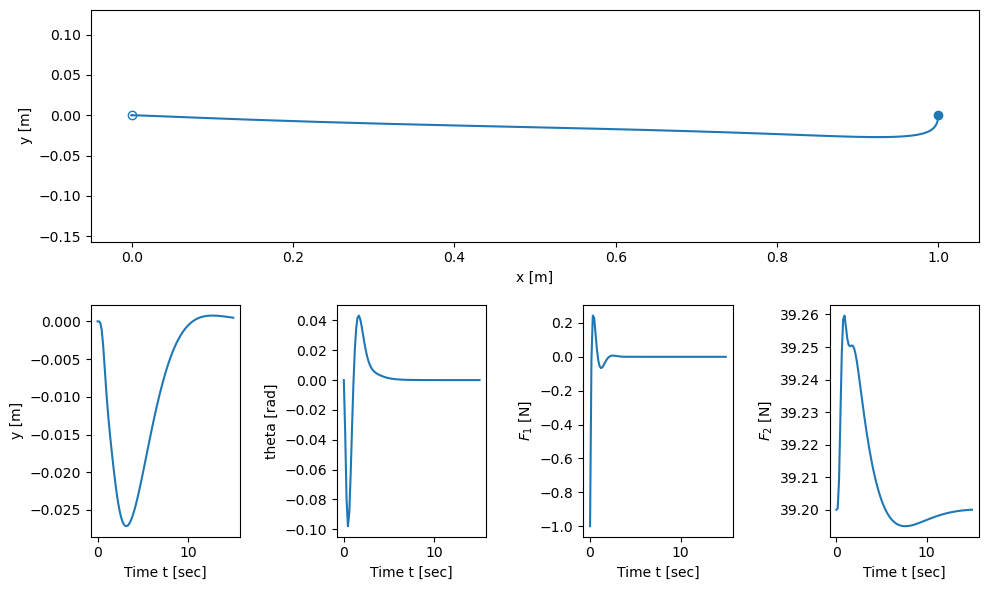

In [54]:
# Generate a step response by setting xd, ud
Tf = 15
T = np.linspace(0, Tf, 100)
xd = np.outer(np.array([1, 0, 0, 0, 0, 0]), np.ones_like(T))
ud = np.outer(ueq, np.ones_like(T))
ref = np.vstack([xd, ud])

response = ct.input_output_response(pvtol_closed, T, ref, xeq)
fig = plot_results(response.time, response.states, response.outputs[6:])

This controller does a pretty good job.  We see in the top plot the $x$, $y$ projection of the trajectory, with the open circle indicating the starting point and the closed circle indicating the final point.  The bottom set of plots show the altitude and pitch as functions of time, as well as the input forces.  All of the signals look reasonable.

The limitations of the linear controller can be seen if we take a larger step, say 10 meters.

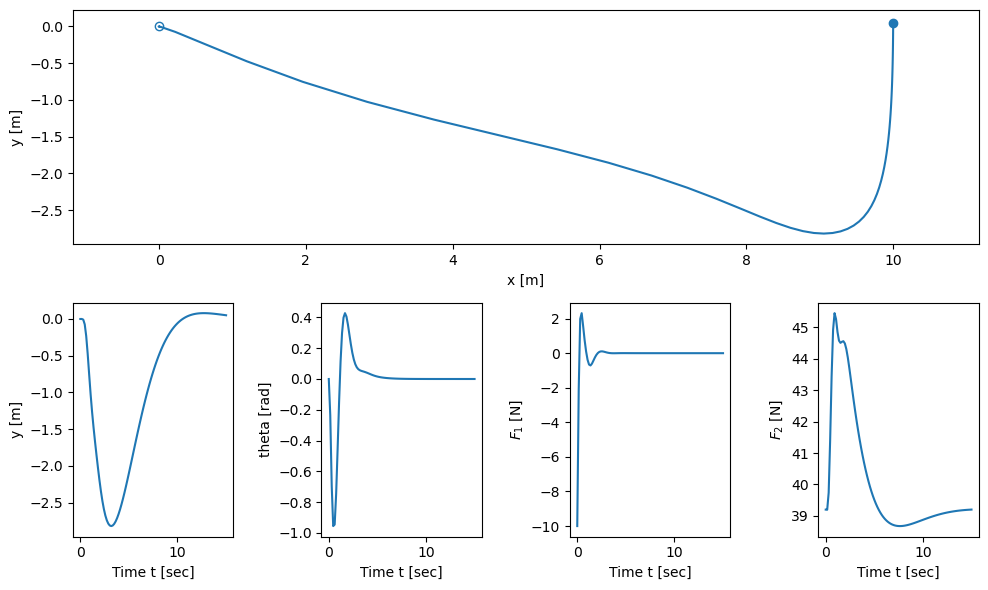

In [55]:
xd = np.outer(np.array([10, 0, 0, 0, 0, 0]), np.ones_like(T))
ref = np.vstack([xd, ud])
response = ct.input_output_response(pvtol_closed, T, ref, xeq)
fig = plot_results(response.time, response.states, response.outputs[6:])

We now see that the trajectory looses significant altitude ($> 2.5$ meters).  This is because the linear controller sees a large initial error and so it applies very large input forces to correct for the error ($F_1 \approx -10$ N at $t = 0$.  This causes the aircraft to pitch over to a large angle (almost $-60$ degrees) and this causes a large loss in altitude.

We will see in the [Lecture 6](cds110-L6a_kincar-trajgen) how to remedy this problem by making use of feasible trajectory generation.